# Introduction


# Data

Datasets used:
    [1]. given dataset
    [2]. Amazon and Best Buy electronics review dataset: https://www.kaggle.com/datafiniti/amazon-and-best-buy-electronics
            

In [3]:
GOOGLE_DRIVE = False

In [6]:
# Importing different libraries
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
if GOOGLE_DRIVE:
    # Importing data from google drive
    from google.colab import drive
    drive.mount('/content/drive')
    # Importing data from google drive
    df = pd.read_csv("drive/My Drive/dataset/twitter_sentiment/tweet_product_company.csv", 
                     encoding='unicode_escape')
else:
    df = pd.read_csv('data/tweet.csv', encoding='unicode_escape')

In [10]:
df.columns=['text', 'product', 'target']
df.head()

,text,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [11]:
df.shape

(9093, 3)

In [12]:
df['target'].value_counts(1)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: target, dtype: float64

# Round 1: Positive and Negative Emotions Only

In [35]:
# Copies only positive and negative emotions from the dataset
df1 = df[(df['target']=='Positive emotion') | (df['target']=='Negative emotion')].copy()

In [14]:
df1['target'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: target, dtype: int64

> There is a great imbalance in class... Possible get around:

    [1] SMOTE - oversampling
    [2] Undersampling - since we do not have many data, we will not use undersampling technique
    [3] class_weight

## Tokenizing

In [332]:
def process_text(tweet,
                 tokenizer='regex',
                 pattern="([a-zA-Z]+(?:'[a-z]+)?)",
                 stopwords_list=stopwords.words('english') + list(string.punctuation)):
    """
    Removes stopwords and tokenizes an input tweet/text.
    
    Args:
        tweet (str): text that needs to be processed
        
        tokenizer (str): chooses different types of tokenizer
                         {'word', 'regex', 'tweet'}
        
        pattern (str): RegEx pattern which will be used to tokenize the input text.
                       Not needed unless tokenizer is set to 'regex'.
        
        stopwords_list (list): List of stopwords that need to be removed from tokens.
    

    Return:
        tokens_stopped (list): List of words that are tokenized from input text
    """
    if tokenizer == 'regex':
        # Tokenizes using given regex pattern
        tokens = nltk.regexp_tokenize(tweet, pattern)
    elif tokenizer == 'tweet':
        tokens = TweetTokenizer().tokenize(tweet)
    elif tokenizer == 'word':
        tokens = word_tokenize(tweet)
    
    # Filters out all the stop words
    if stopwords_list:
        tokens_stopped = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    
        return tokens_stopped
    else:
        return tokens

In [333]:
# Tokenizes each tweet from dataset
df1['text_token'] = [process_text(x, stopwords_list=None) for x in df1['text']]

In [334]:
df1.head()

,text,product,target,text_token
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[wesley, I, have, a, G, iPhone, After, hrs, tw..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[jessedee, Know, about, fludapp, Awesome, iPad..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[swonderlin, Can, not, wait, for, iPad, also, ..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, I, hope, this, year's, festival, isn't,..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris..."


In [169]:
# Total vocabularies used in the tweets
total_tweets = []
vocab_tweets = set()
for tweet in df1['text_token']:
    total_tweets += tweet
    vocab_tweets.update(tweet)
total_tweets_freqdist = FreqDist(total_tweets)

# Prints out top 200 most used vocabularies
total_tweets_freqdist.most_common(200)

[('sxsw', 3739),
 ('mention', 2507),
 ('ipad', 1449),
 ('link', 1319),
 ('rt', 1075),
 ('apple', 1011),
 ('google', 830),
 ('iphone', 711),
 ('quot', 639),
 ('store', 596),
 ('app', 461),
 ('new', 403),
 ('austin', 323),
 ('amp', 233),
 ('android', 233),
 ('pop', 231),
 ('get', 182),
 ('launch', 182),
 ('circles', 156),
 ('social', 155),
 ('like', 154),
 ('line', 150),
 ('time', 147),
 ('via', 146),
 ('great', 145),
 ('party', 139),
 ('one', 135),
 ("i'm", 132),
 ('today', 132),
 ('free', 128),
 ('day', 128),
 ('cool', 125),
 ('w', 120),
 ('maps', 115),
 ('mobile', 115),
 ('apps', 113),
 ('people', 111),
 ('go', 111),
 ('good', 110),
 ('sxswi', 108),
 ('network', 104),
 ('awesome', 99),
 ('love', 98),
 ('temporary', 94),
 ('opening', 91),
 ('check', 89),
 ('downtown', 89),
 ('see', 89),
 ('got', 88),
 ('need', 85),
 ('going', 80),
 ('thanks', 80),
 ('even', 80),
 ('popup', 79),
 ('called', 77),
 ('mayer', 76),
 ('first', 75),
 ('open', 75),
 ('major', 73),
 ('around', 72),
 ('best', 72

In [170]:
from sklearn.model_selection import train_test_split

In [171]:
# Splits the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df1[['text_token']],
                                                    df1['target'], 
                                                    random_state=42)

In [191]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
np.random.seed(0)

In [228]:
# The following function allows us to use alread-tokenized tweets in TF-IDF vectorizer
# Source: https://stackoverflow.com/questions/48671270/use-sklearn-tfidfvectorizer-with-already-tokenized-inputs
def identity_tokenizer(text):
    return text
# Word Vectorizer
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)

In [229]:
X_train_vect = vectorizer.fit_transform(X_train['text_token'])
X_test_vect = vectorizer.transform(X_test['text_token'])

## Models

In [230]:
import src.useful_codes as uc

In [231]:
pd.Series(y_test).value_counts(1)

Positive emotion    0.845547
Negative emotion    0.154453
Name: target, dtype: float64

In [272]:
def run_model(name, params=None, data=None, report=True):
    """
    Fits and evaluates model
    
    Args:
        name (str): Name of model.
                    {'RF', 'XGB', 'NB', 'SVM'}
                    
        params (dict): Dictionary of parameters for the model.
        
        **data (dataframe): X_train, X_test, y_train, y_test
        
        report (bool): True if classification report/confusion matrix is wanted.
    
    Returns:
        model (object): fitted model
    """

    if name == 'RF':
        if params:
            clf = RandomForestClassifier(**params)
        else:
            clf = RandomForestClassifier()
    elif name == 'NB':
        if params:
            clf = MultinomialNB(**params)
        else:
            clf = MultinomialNB()
    elif name == 'XGB':
        if params:
            clf = XGBClassifier(**params)
        else:
            clf = XGBClassifier()
    
    clf.fit(data['X_train'], data['y_train'])
    
    if report:
        uc.evaluate_clf_model(clf, data['X_train'], data['y_train'],
                              data['X_test'], data['y_test'],
                              classes=['Negative emotion', 'Positive emotion'],
                              label=f'{name} Classifier');
    return clf

------------------------------------------------------------
[i] CLASSIFICATION REPORT Rf Classifier
------------------------------------------------------------
Train Accuracy :  1.0
Test Accuracy :  0.8805
                  precision    recall  f1-score   support

Negative emotion       0.90      0.26      0.40       137
Positive emotion       0.88      0.99      0.93       750

        accuracy                           0.88       887
       macro avg       0.89      0.63      0.67       887
    weighted avg       0.88      0.88      0.85       887

------------------------------------------------------------




RandomForestClassifier()

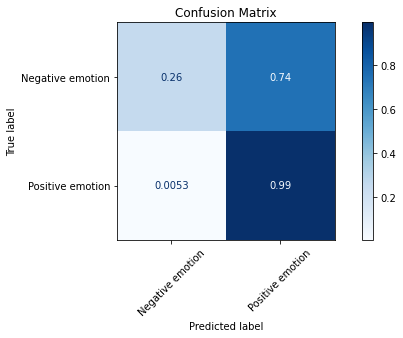

In [265]:
run_model(name='RF',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT Rf Classifier
------------------------------------------------------------
Train Accuracy :  1.0
Test Accuracy :  0.8681
                  precision    recall  f1-score   support

Negative emotion       0.86      0.18      0.29       137
Positive emotion       0.87      0.99      0.93       750

        accuracy                           0.87       887
       macro avg       0.86      0.58      0.61       887
    weighted avg       0.87      0.87      0.83       887

------------------------------------------------------------




RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       n_estimators=500)

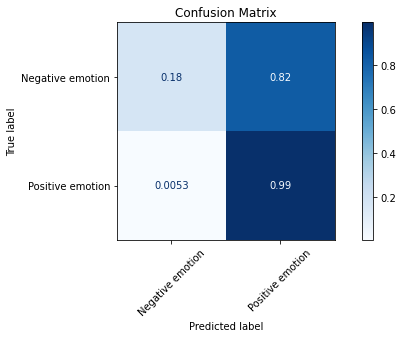

In [266]:
run_model(name='RF',
          params=dict(n_estimators=500,
                      class_weight='balanced',
                      max_features='sqrt'),
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT Nb Classifier
------------------------------------------------------------
Train Accuracy :  0.8564
Test Accuracy :  0.8534
                  precision    recall  f1-score   support

Negative emotion       1.00      0.05      0.10       137
Positive emotion       0.85      1.00      0.92       750

        accuracy                           0.85       887
       macro avg       0.93      0.53      0.51       887
    weighted avg       0.88      0.85      0.79       887

------------------------------------------------------------




MultinomialNB()

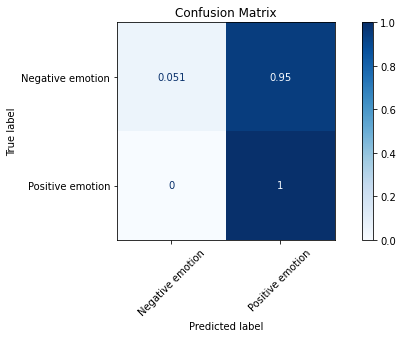

In [262]:
run_model(name='NB',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT Xgb Classifier
------------------------------------------------------------
Train Accuracy :  0.8655
Test Accuracy :  0.8602
                  precision    recall  f1-score   support

Negative emotion       0.84      0.12      0.21       137
Positive emotion       0.86      1.00      0.92       750

        accuracy                           0.86       887
       macro avg       0.85      0.56      0.56       887
    weighted avg       0.86      0.86      0.81       887

------------------------------------------------------------




XGBClassifier()

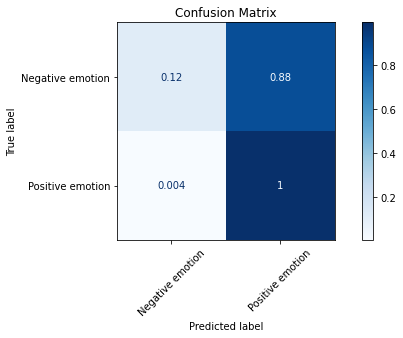

In [267]:
run_model(name='XGB',
          data={'X_train': X_train_vect, 'X_test': X_test_vect, 
                "y_train": y_train, 'y_test': y_test})

## SMOTE

In [271]:
# Oversamples
X_train_vect_smote, y_train_smote = SMOTE().fit_resample(X_train_tf_idf, y_train)

------------------------------------------------------------
[i] CLASSIFICATION REPORT RF Classifier
------------------------------------------------------------
Train Accuracy :  1.0
Test Accuracy :  0.8771
                  precision    recall  f1-score   support

Negative emotion       0.83      0.26      0.39       137
Positive emotion       0.88      0.99      0.93       750

        accuracy                           0.88       887
       macro avg       0.86      0.62      0.66       887
    weighted avg       0.87      0.88      0.85       887

------------------------------------------------------------




RandomForestClassifier()

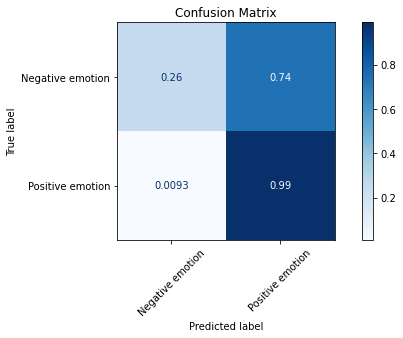

In [273]:
run_model(name='RF',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT NB Classifier
------------------------------------------------------------
Train Accuracy :  0.956
Test Accuracy :  0.8309
                  precision    recall  f1-score   support

Negative emotion       0.47      0.73      0.57       137
Positive emotion       0.95      0.85      0.89       750

        accuracy                           0.83       887
       macro avg       0.71      0.79      0.73       887
    weighted avg       0.87      0.83      0.84       887

------------------------------------------------------------




MultinomialNB()

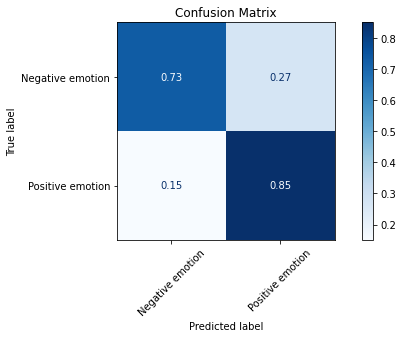

In [275]:
run_model(name='NB',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

------------------------------------------------------------
[i] CLASSIFICATION REPORT XGB Classifier
------------------------------------------------------------
Train Accuracy :  0.8905
Test Accuracy :  0.8602
                  precision    recall  f1-score   support

Negative emotion       0.70      0.17      0.27       137
Positive emotion       0.87      0.99      0.92       750

        accuracy                           0.86       887
       macro avg       0.78      0.58      0.60       887
    weighted avg       0.84      0.86      0.82       887

------------------------------------------------------------




XGBClassifier()

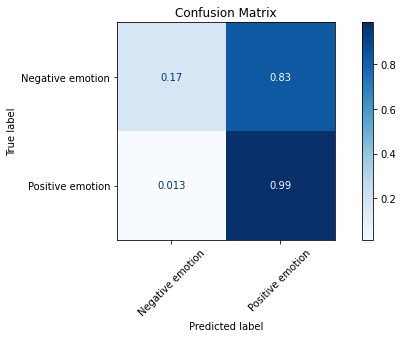

In [276]:
run_model(name='XGB',
          data={'X_train': X_train_vect_smote, 'X_test': X_test_vect, 
                "y_train": y_train_smote, 'y_test': y_test})

### Using Additional Dataset

We have seen that we have a couple of problems with the given dataset:
    
    [1]. Imbalance
    
            No emotion toward brand or product    0.592654
            Positive emotion                      0.327505
            Negative emotion                      0.062686
            I can't tell                          0.017156
            
    [2]. Relatively small data size: 9093 rows
    * The total number of rows may seem like it's a reasonable number, but considering its class imbalance, the number is quite small.

So, to get around this, what we will do is that we will implement a dataset that contains electronic reviews from Amazon and BestBuy.

*Reminder: This dataset can be obtained at https://www.kaggle.com/datafiniti/amazon-and-best-buy-electronics

In [296]:
# Import the new dataset
df2 = pd.read_csv('data/amazon_review.csv')

In [297]:
df2.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


## Preprocessing

In [303]:
df2 = df2[['reviews.text', 'reviews.rating']]

In [304]:
df2['reviews.rating'].value_counts()

5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: reviews.rating, dtype: int64

In [305]:
score_dict = {5.0:'positive', 4.0:'positive', 
              3.0:'neutral', 
              2.0:'negative', 1.0:'negative'}

In [306]:
df2.dropna(inplace=True)

In [307]:
df2['sentiment'] = df2['reviews.rating'].apply(lambda x: score_dict[x])

<AxesSubplot:>

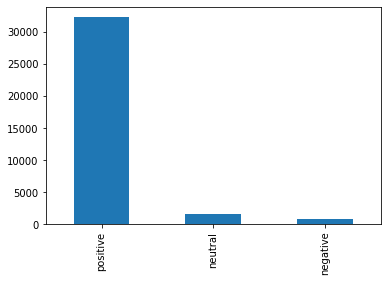

In [335]:
df2['sentiment'].value_counts().plot.bar()

In [311]:
df2['text_token'] = list(map(process_text, df2['reviews.text']))

In [312]:
df2

,reviews.text,reviews.rating,sentiment,text_token
0,This product so far has not disappointed. My c...,5.0,positive,"[product, far, disappointed, children, love, u..."
1,great for beginner or experienced person. Boug...,5.0,positive,"[great, beginner, experienced, person, bought,..."
2,Inexpensive tablet for him to use and learn on...,5.0,positive,"[inexpensive, tablet, use, learn, step, nabi, ..."
3,I've had my Fire HD 8 two weeks now and I love...,4.0,positive,"[i've, fire, hd, two, weeks, love, tablet, gre..."
4,I bought this for my grand daughter when she c...,5.0,positive,"[bought, grand, daughter, comes, visit, set, u..."
...,...,...,...,...
34655,This is not appreciably faster than any other ...,3.0,neutral,"[appreciably, faster, higher, amp, charger, us..."
34656,Amazon should include this charger with the Ki...,1.0,negative,"[amazon, include, charger, kindle, fact, they'..."
34657,Love my Kindle Fire but I am really disappoint...,1.0,negative,"[love, kindle, fire, really, disappointed, kin..."
34658,I was surprised to find it did not come with a...,1.0,negative,"[surprised, find, come, type, charging, cords,..."


In [313]:
'not' in stopwords

TypeError: argument of type 'WordListCorpusReader' is not iterable

# Using Deep Learning